# Part 2: Resolution

In [4]:
# IPython magics
%matplotlib inline

In [5]:
# Import packages
import matplotlib
#matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
import matplotlib.image
import seaborn as sb
import numpy as np
import scipy.stats as stats
import scipy.constants as consts
import scipy.ndimage



## Maxwell-Boltzmann distribution
Measurement of 1D particle energy distributions. The canonical Maxwell-Boltzmann distribution
is given by:

\\( f(v) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{mv^2}{2k_BT}\right) \\)

where m is the mass of the species, n is the (number) density, k<sub>B</sub>T is the temperature, and v is the speed at which we are looking for the distribution function. Here we will use a "drifting Maxwellian" which is a Maxwell-Boltzmann distribution that is moving at a relative velocity to the frame of the distribution.

\\( f(\mathbf{v}) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{m(\mathbf{v_0}-\mathbf{v})^2}{2k_BT}\right) \\)

We also need to convert the distribution function to units of differential number flux, also known as DNF [m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>], and differential energy flux, also known as DEF [J m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>]. Note that the "J/J" part of the DEF units is retained to indicate DEF and to avoid ambiguity.

\\( J_N = f\frac{v^2}{m} \\)  
\\( J_E = f\frac{v^4}{2m} \\)

In our code we will implement the drifting Maxwellian and conversions as a Python lambda functions.

In [6]:
# Distribution function for a drifting isotropic Maxwell-Boltzmann distribution with density n [m^-3], temperature kT [eV],
# velocity v0 [km/s], direction of flow (th0,ph0) [deg], for a species of mass m [u], charge state q [dimensionless integer],
# at energies per charge EperQ [eV/q], look direction (th,ph) [deg]. Returns the value of the distribution function
# in units of s^3/m^6 at the velocity (vx,vy,vz) [m/s] - note the different units for velocity.
def dist_mb(m, q, n, v0, th0, ph0, kT, EperQ, th, ph):
    v0x = v0*1e3*np.cos(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0y = v0*1e3*np.sin(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0z = v0*1e3*np.cos(th0*np.pi/180.0)
    v = np.sqrt(2.0*q*EperQ*consts.e/(m*consts.u))
    vx = v*np.cos(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vy = v*np.sin(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vz = v*np.cos(th*np.pi/180.0)
    x = 0.5*m*consts.u*v0*v0*1e6 + EperQ*consts.e*q - m*consts.u*(v0x*vx + v0y*vy + v0z*vz)
#x = 0.5*m*consts.u*((v0x-vx)**2 + (v0y-vy)**2 + (v0z-vz)**2)
    return n*((m*consts.u/(2*np.pi*kT*consts.e))**(1.5))*np.exp(-x/(kT*consts.e))

# Functions to convert from distribution function to flux units (both differential energy flux and differential number flux)
# f in units of s^3 m^-6, EperQ in units of eV/q, m in units of u, and q is an integer
todnf = lambda f, EperQ, m, q: f*EperQ*consts.e*2*(q/(m*consts.u))**2
todef = lambda f, EperQ, m, q: f*((EperQ*consts.e)**2)*q*2*(q/(m*consts.u))**2

Generate a solar wind spectrum with H+ and He++ moving at 450 km/s with a temperature of 10 eV.

Text(0,0.5,'Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')

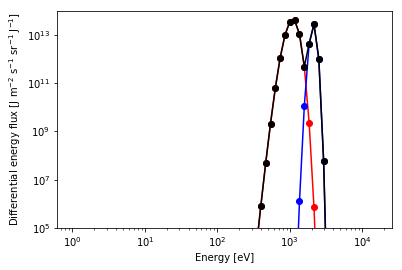

In [7]:
E = np.logspace(0,4.2,64) # in eV/q
f_h = dist_mb(1.007825032241, 1.0, 1e6*(1-0.04), 450.0,0.0,0.0, 10.0, E, 0.0, 0.0)
f_he = dist_mb(4.00260325415, 2.0, 1e6*0.04, 450.0,0.0,0.0, 10.0, E, 0.0, 0.0)
plt.loglog(E, todef(f_h,E,1.007825032241,1.0),'or')
plt.loglog(E, todef(f_h,E,1.007825032241,1.0),'-r')
plt.loglog(E,todef(f_he,E,4.00260325415,2.0),'ob')
plt.loglog(E,todef(f_he,E,4.00260325415,2.0),'-b')
plt.loglog(E, todef(f_h,E,1.007825032241,1.0)+todef(f_he,E,4.00260325415,2.0),'ok')
plt.loglog(E, todef(f_h,E,1.007825032241,1.0)+todef(f_he,E,4.00260325415,2.0),'-k')
plt.xlabel('Energy [eV]')
plt.ylim([1e5,1e14])
plt.ylabel('Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')

Here the speed of the solar wind, combined with the low temperature produces a very narrow beam in energy. To properly forward-model this we need to account for the finite width of each energy bin.

In [8]:
# Define some parameters of the energy table and geometric/calibration factor.
energy_resolution = 0.18
num_energy_bins = 64
energy_table_lower = np.zeros(num_energy_bins)
energy_table_upper = np.zeros(num_energy_bins)
energy_table_lower[0] = 1.0
energy_table_upper[0] = 1.0*(1+1*energy_resolution)
for i in range(1,num_energy_bins):
    energy_table_lower[i] = energy_table_upper[i-1]
    energy_table_upper[i] = energy_table_lower[i]*(1+1*energy_resolution)
energy_table_centre = (energy_table_upper+energy_table_lower)/2.0

G = 5e-10
quantumeff = lambda E, scale=10000: np.exp(-(E/10000)**2)

Now lets look at the counts across a single energy/charge bin.

3277.02699613
3277.02699613


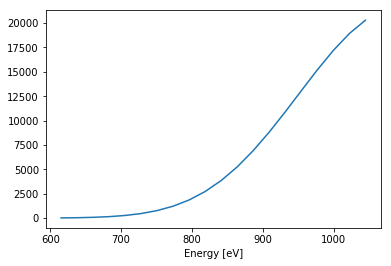

In [14]:
# Bin number, and now many sub-samples to take
i = 40
n = 20

# Instrument response is modelled as a Gaussian.
fwhm = energy_table_upper[i]-energy_table_lower[i]
sig = fwhm/(2.0*np.sqrt(2.0*np.log(2)))
tmp_energies = np.linspace(energy_table_lower[i]*(1-energy_resolution),energy_table_upper[i]*(1+energy_resolution),n)
eps = quantumeff(tmp_energies)
de_tmp_energies = (np.max(tmp_energies)-np.min(tmp_energies))/n
f_h = dist_mb(1.007825032241, 1.0, 1e6*(1-0.04), 450.0,0.0,0.0, 10.0, tmp_energies, 0.0, 0.0)
inst_response = np.exp(-0.5*((tmp_energies-energy_table_centre[i])/sig)**2)/(sig*np.sqrt(2*np.pi))

print(np.sum(inst_response*todef(f_h,tmp_energies,1.007825032241,1.0)*G*eps*de_tmp_energies))

plt.plot(tmp_energies, todef(f_h,tmp_energies,1.007825032241,1.0)*G*eps)
plt.xlabel('Energy [eV]')

# This function returns the counts in a single bin for an under-resolved population.
def underresolve(fun, E_low, E_up, E_c, dEoverE, n=20):
    fwhm = E_up-E_low
    sig = fwhm/(2.0*np.sqrt(2.0*np.log(2)))
    tmp_energies = np.linspace(E_low*(1-dEoverE), E_up*(1+dEoverE), n)
    de_tmp_energies = (E_up*(1+dEoverE)-E_low*(1-dEoverE))/n
    inst_response = np.exp(-0.5*((tmp_energies-E_c)/sig)**2)/(sig*np.sqrt(2*np.pi))
    return np.sum(inst_response*fun(tmp_energies)*de_tmp_energies)

# Check.
print(underresolve(lambda E: todef(f_h,E,1.007825032241,1.0)*G*eps, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution))


## Synthetic under-resolved spectrum
Finally, we can fully sample the analytic spectrum, taking into account the sub-optimal resolution.

Text(0,0.5,'Counts/accumulation')

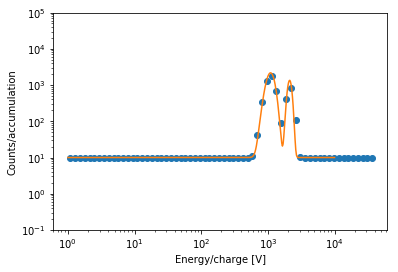

In [15]:
# Instrument parameters.
energy_resolution = 0.18
num_energy_bins = 64
energy_table_lower = np.zeros(num_energy_bins)
energy_table_upper = np.zeros(num_energy_bins)
energy_table_lower[0] = 1.0
energy_table_upper[0] = 1.0*(1+1*energy_resolution)
for i in range(1,num_energy_bins):
    energy_table_lower[i] = energy_table_upper[i-1]
    energy_table_upper[i] = energy_table_lower[i]*(1+1*energy_resolution)
energy_table_centre = (energy_table_upper+energy_table_lower)/2.0

# Calculate the counts
f = np.zeros(num_energy_bins)
deffun = lambda E: (todef(dist_mb(1.007825032241, 1.0, 1e5*(1-0.04), 450.0,0.0,0.0, 10.0, E, 0.0, 0.0),E,1.007825032241,1.0) +
                        todef(dist_mb(4.00260325415, 2.0, 1e5*0.04, 450.0,0.0,0.0, 10.0, E, 0.0, 0.0),E,4.00260325415,2.0))*G*quantumeff(E)+10.0
for i in range(num_energy_bins):
    f[i] = underresolve(deffun, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution)

# Generate a high resolution spectrum for comparison
E_hi = np.logspace(0,4,400)
def_hi = deffun(E_hi)
    
plt.loglog(energy_table_centre,f,'o')
plt.loglog(E_hi,def_hi)
plt.ylim([1e-1,1e5])
plt.xlabel('Energy/charge [V]')
plt.ylabel('Counts/accumulation')

## Let's try to fit this - using all the ingredients but using a different fitting method

Step: n_h=100000.0 n_he=10000.0 v=420.0 kT=10.0
Step: n_h=100000.0 n_he=10000.0 v=420.0 kT=10.0
Step: n_h=99062.5 n_he=9437.5 v=433.75 kT=10.84375
Step: n_h=98906.25 n_he=9343.75 v=439.375 kT=10.234375
Step: n_h=94609.375 n_he=9765.625 v=444.0625 kT=10.4765625
Step: n_h=94609.375 n_he=9765.625 v=444.0625 kT=10.4765625
Step: n_h=97231.4453125 n_he=9276.3671875 v=454.04296875 kT=10.73388671875
Step: n_h=97231.4453125 n_he=9276.3671875 v=454.04296875 kT=10.73388671875
Step: n_h=98660.35461425781 n_he=9492.111206054688 v=449.07684326171875 kT=10.463371276855469
Step: n_h=96377.13432312012 n_he=9574.93782043457 v=450.7905960083008 kT=10.755284309387207
Step: n_h=100714.85042572021 n_he=9134.781837463379 v=453.27234268188477 kT=10.826094150543213
Step: n_h=98312.73138523102 n_he=9413.47348690033 v=446.27748250961304 kT=10.673715054988861
Step: n_h=98312.73138523102 n_he=9413.47348690033 v=446.27748250961304 kT=10.673715054988861
Step: n_h=99083.64541828632 n_he=9256.636187434196 v=448.850876

Step: n_h=77387.45232257336 n_he=4090.663187631758 v=451.919513799167 kT=8.974837480433347
Step: n_h=77387.45232257336 n_he=4090.663187631758 v=451.919513799167 kT=8.974837480433347
Step: n_h=77580.08234009269 n_he=4104.877503130152 v=451.88686298561964 kT=8.9858593430041
Step: n_h=77580.08234009269 n_he=4104.877503130152 v=451.88686298561964 kT=8.9858593430041
Step: n_h=77242.49889064587 n_he=4096.077934207042 v=451.8916375978647 kT=8.961913079328397
Step: n_h=77242.49889064587 n_he=4096.077934207042 v=451.8916375978647 kT=8.961913079328397
Step: n_h=77242.49889064587 n_he=4096.077934207042 v=451.8916375978647 kT=8.961913079328397
Step: n_h=77242.49889064587 n_he=4096.077934207042 v=451.8916375978647 kT=8.961913079328397
Step: n_h=77242.49889064587 n_he=4096.077934207042 v=451.8916375978647 kT=8.961913079328397
Step: n_h=77338.52134772416 n_he=4102.403123029708 v=451.90040467877776 kT=8.973315227110982
Step: n_h=77338.52134772416 n_he=4102.403123029708 v=451.90040467877776 kT=8.973315

         Iterations: 217
         Function evaluations: 405
[  7.74272141e+04   4.10505276e+03   4.51896226e+02   8.97952391e+00]


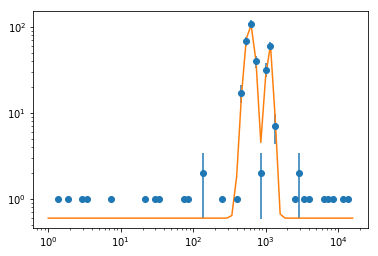

In [20]:
# Function to calculate a spectrum given the parameters in the matrix p
def spec(p):
    tmpfun = lambda E: (todef(dist_mb(1.007825032241, 1.0, p[0], p[2],0.0,0.0, p[3], E, 0.0, 0.0),E,1.007825032241,1.0) +
         todef(dist_mb(4.00260325415, 2.0, p[1], p[2],0.0,0.0, p[3], E, 0.0, 0.0),E,4.00260325415,2.0))*G*quantumeff(E)+10.0

    for i in range(num_energy_bins):
        f[i] = underresolve(tmpfun, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution)


    return f*4/64

# Calculate the cost function.
def fitfun(p):
    return np.sqrt(np.sum((spec(p)-C)**2))

# Perform the fit. Notice this is iterative.
p = scipy.optimize.fmin(fitfun, [1e5,1e4,400,10], disp=True, callback=lambda p: print('Step: n_h={} n_he={} v={} kT={}'.format(p[0],p[1],p[2],p[3])))

plt.errorbar(E,C,yerr=np.sqrt(C),fmt='o')
#plt.loglog(E,f*taua)
plt.loglog(E,spec(p))

print(p)

## Explore the chi-square space in the dimension of velocity and temperature

1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40


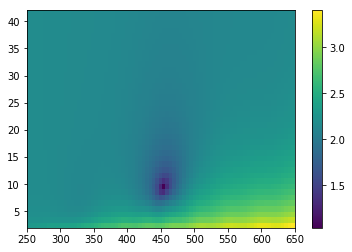

In [22]:
x = np.linspace(250,650,80)
y = np.linspace(2,42,40)
rms = np.zeros((80,40))
for iy in range(40):
    print('{}/{}'.format(iy+1,40))
    for ix in range(80):
        rms[ix,iy] = fitfun([p[0],p[1],x[ix],y[iy]])
plt.pcolor(x,y,np.log10(rms.T))
plt.colorbar()